In [1]:
import numpy as np
import xarray as xr

from ase import units as u

In [2]:
# stuff for plotting
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
DS = xr.open_dataset('md/trajectory.nc')

In [4]:
print(DS)

<xarray.Dataset>
Dimensions:           (I: 120, a: 3, b: 3, time: 2001)
Coordinates:
  * time              (time) float64 0.0 5.0 10.0 ... 9.99e+03 9.995e+03 1e+04
Dimensions without coordinates: I, a, b
Data variables:
    positions         (time, I, a) float64 ...
    displacements     (time, I, a) float64 ...
    velocities        (time, I, a) float64 ...
    momenta           (time, I, a) float64 ...
    forces            (time, I, a) float64 ...
    kinetic_energy    (time) float64 ...
    potential_energy  (time) float64 ...
    stress            (time, a, b) float64 ...
    pressure          (time) float64 ...
    temperature       (time) float64 ...
Attributes:
    System Name:                BaHfO3
    natoms:                     120
    time unit:                  fs
    timestep:                   5.000000000000001
    nsteps:                     2000
    volume:                     1734.910767022666
    symbols:                    ['Ba', 'Ba', 'Ba', 'Ba', 'Ba', 'Ba', 'Ba', 

In [5]:
# extract masses and symbols as numpy arrays
masses = np.array(DS.attrs['masses'])
symbols = np.array(DS.attrs['symbols'])

In [6]:
# extract velocities, temperatures, masses, symbols
temperature = DS.temperature
velocities = DS.velocities

masses = np.array(DS.attrs['masses'])
symbols = np.array(DS.attrs['symbols'])

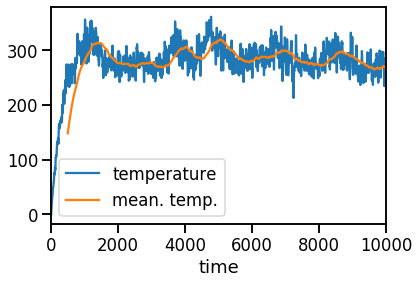

In [7]:
# example plot: convert to pandas dataframe and plot
df = temperature.to_dataframe()

df['mean. temp.'] = df.temperature.rolling(window=100).mean()

ax = df.plot()

In [8]:
# create dictionary that turns symbol -> mass
mass_dct = {}
for sym, mass in zip(symbols, masses):
    mass_dct[sym] = mass

In [9]:
# look at norm of velocities
v_norm = velocities.reduce(np.linalg.norm, axis=2)
v_norm.shape

(2001, 120)

In [10]:
velocities.dims

('time', 'I', 'a')

In [11]:
# get velocities for each unique element:
elements = np.unique(symbols)

## Plot Velocity Distribution function and compare to Maxwell-Boltmann

In [12]:
def mb(v, m, T=300, normed=True):
    """Maxwell Boltzmann velocity distribution"""
    # v *= u.fs**.5
    
    m = v**2 * np.exp(- m * v**2 / 2 / T / u.kB)
    
    if normed:
        dv = v[1] - v[0]
        scale = np.sum(m) * dv
        m /= scale
        
    return m

Text(0.5, 0, '|v| [ase velocity unit]')

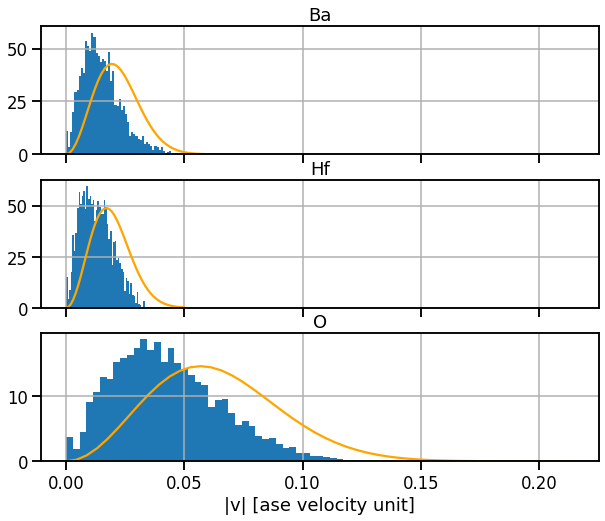

In [13]:
start = 000
window = slice(start, start + 100)

fig, axs = plt.subplots(nrows=len(elements), sharex=True, figsize=(10, 8))

for ii, elem in enumerate(elements):
    ax = axs[ii]  # the subplots axis

    # get velocities for element in time window
    v = v_norm[window, symbols == elem]

    # create pandas.Series form xarray.DataArray and plot histogram normalized to 1
    v.to_series().hist(ax=ax, bins=50, density=True)

    # create analytic Maxwell-Boltzmann function for the domain of velocities
    m = mass_dct[elem]  # mass for element
    domain = (v.min(), v.max() * 1.5)
    v_ax = np.linspace(*domain, num=50)
    p = mb(v_ax, m)

    ax.plot(v_ax, p, color="orange")

    ax.set_title(elem)
ax.set_xlabel("|v| [ase velocity unit]")